Author: Abdulrahman Altahhan, 2025

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Worksheet 10- Tabular Methods: n-steps Bootstrapping Tabular Methods

**Learning outcomes**
1. understand how to generalize a one-step methods to n-step methods
2. understand the trend associated with n-steps methods 
3. understand that intermediate n values usually works the best 
4. generalise n-step prediction methods to n-step control methods

**Reading**:
The accompanying reading of this lesson is **chapter 7** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

In the previous lesson, we saw how a TD update rule defined in terms of the next reward and state as the target can effectively converge to useful state and action-value functions. It took the form:

$V(S_{t}) = V(S_{t}) + \alpha[R_{t+1} + \gamma V(S_{t+1}) - V(S_{t}) ]$

This is a one-step update because one reward available in the current step is used. It can be written as

$G_{t} = R_{t+1} + \gamma V(S_{t+1})$

$V(S_{t}) = V(S_{t}) + \alpha[ G_{t} - V(S_{t}) ]$

where $G_{t}$ is a one-step return.

In this lesson, we study the effect of increasing the number of steps considered for the target. In particular, we study the effect of collecting rewards for n steps and substituting the one-step return with the n-step return written as the discounted sum of the n rewards plus the value function for the n-th step state.

In other words, we define the n-step return as

$G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \gamma^{2} R_{t+3} +...+ \gamma^{n-1} R_{t+n} + \gamma^{n}V(S_{t+n})$

And the update rule that uses this n-step return is:

$V(S_{t}) = V(S_{t}) + \alpha[G_{t:t+n} - V(S_{t}) ]$

When we want to make in which time step, we are conducting this update, we add a subscript for the V function that represents the time step at which the estimate is referring to 

$G_{t:t+n} = R_{t+1} + \gamma R_{t+2} + \gamma^{2} R_{t+3} +...+ \gamma^{n-1} R_{t+n} + \gamma^{n}V_{t+n-1}(S_{t+n})$

$V_{t+n}(S_{t}) = V_{t+n-1}(S_{t}) + \alpha[G_{t:t+n} - V_{t+n-1}(S_{t}) ]$


In [1]:
%matplotlib inline

In [2]:
from rl.rl import *

## Adjusting an MRP class

First, let us develop our MRP class to accommodate waiting for n-1 steps before obtaining the $G_{t:t+n}$. In each step, we must also create a G function to obtain the $G_{t:t+n}$. Finally, we would need to alter our stopping criteria to wait for extra n-1 steps at the end to ensure we update the latest n-1 state values since we are always lagging n-1 steps during the episode.

In [3]:
class MRP(MRP):
    
    def __init__(self, n=1, **kw):
        super().__init__(**kw)
        self.n = n

    #----------------------------------- 🐾steps as per the algorithm style --------------------------
    def stop_ep(self, done):
        return self.stop_(done) or (self.t+1 >= self.max_t-1 and self.store)

    def stop_(self,done):
        if done:
            self.skipstep +=1                     # holds the count for how many steps after ep is finished (will reach n-1)
            if self.skipstep == self.n: 
                self.t = self.t+1 - self.skipstep # returns t to its original actual count of number of steps.  it is executed before self.t+=1 in interact and hence +1 is necessary
                self.skipstep = 0
                return True
            return False
    
        self.skipstep = 0
        return False
    #-----------------------------------💰 returns --------------------------------------------------
    def G(self, τ1, τn):    # n-steps return, called during an episode   
        
        #if self.γ==1: return self.r[τ1:τn+1].sum() # this saves computation when no dsicount is applied
        Gn = 0
        for t in range(τn, τ1-1, -1): # yields τn-τ1= (τ+n)-(τ+1)= n-1 setps
            Gn = self.γ*Gn + self.r[t] 
            
        return Gn 

## Online TDn 
Now we write our TDn class. It is very similar to TD except that we replace the rn+V[t+1] by the $G_{t:t+n}$. Also as long as the agent did do enough steps (n-1) we skip without doing the update.

In [4]:
class TDn(MRP):
    
    def init(self):
        self.store = True # there is a way to save storage by using t%(self.n+1) but we left it for clarity

    
    # ----------------------------- 🌖 online learning ----------------------    
    def online(self,*args):
        τ = self.t - (self.n-1);  n = self.n
        if τ<0: return
        
        # we take the min so that we do not exceed the episode limit (last step+1)
        τn = τ+n ; τn = min(τn, self.t+1 - self.skipstep)
        τ1 = τ+1
        
        sτ = self.s[τ ]
        sn = self.s[τn]
        done = self.done[τn]
        
        # n steps τ+1,..., τ+n inclusive of both ends
        self.V[sτ] += self.α*(self.G(τ1,τn) + (1- done)*self.γ**n *self.V[sn] - self.V[sτ])

Let us now apply TDn on our simple 5-steps random walk problem.

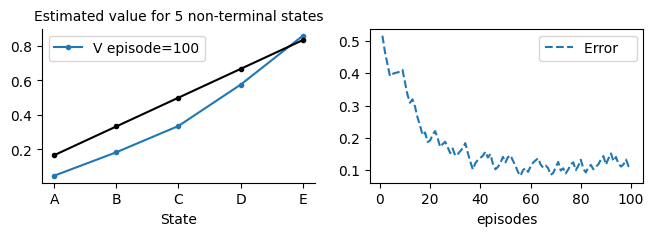

In [5]:
np.random.seed(0)
TDnwalk = TDn(env=randwalk(), v0=0, α=.05, n=4, episodes=100, **demoV()).interact()

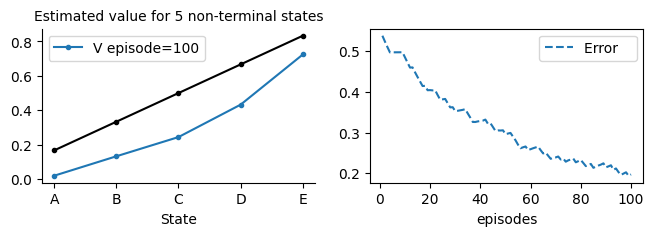

In [6]:
np.random.seed(0)
TDnwalk = TDn(env=randwalk(), v0=0, α=.05, n=1, episodes=100, **demoV()).interact()

In [7]:
TDnwalk.t

18

In [8]:
TDnwalk.Ts

array([ 3,  7,  9, 15, 11,  5,  3,  5, 13, 27,  9,  3, 11,  3, 11,  7,  7,
        7, 13,  3,  7,  5, 15,  7,  5, 13,  3, 23, 13,  9,  3,  7,  9, 17,
       13, 17,  9, 13,  9,  3,  3, 29,  3, 15,  7,  3,  3, 19,  9,  3, 15,
        3,  3,  3, 19,  3, 15,  3,  3,  9,  5,  3,  3,  7,  3,  3,  3,  5,
        3, 11,  7, 11,  3,  5,  9,  5,  3, 19,  5,  9,  5,  3,  5,  3,  5,
        3,  3,  9, 11,  9,  7,  5,  9,  7,  9,  3,  3, 15,  7, 19],
      dtype=uint32)

### TDn and MC Runs on random walk
Let us now  see how a TDn for n=1 and n=5 as well as MC behaves on our usual 5-states random walk on average. To that end as usual we execute several runs.

from MC import MC

In [9]:
def nstepTD_MC_randwalk(env=randwalk(), algorithm=TDn, alglabel='TD'):
    plt.xlim(0, 100)
    plt.ylim(0, .25)
    plt.title('Empirical RMS error, averaged over states')
    n=5
    
    for α in [.05, .1, .15]:
        TDαs = Runs(algorithm=algorithm(env=env, n=1,α=α, v0=.5),  runs=100, plotE=True).interact(label='%s α= %.2f'%(alglabel,α), frmt='.-')
    
    for α in [.05, .1, .15]:
        TDαs = Runs(algorithm=algorithm(env=env,n=n,α=α, v0=.5),  runs=100, plotE=True).interact(label= '%s α= %.2f n=%d'%(alglabel,α,n), frmt='-')

    for α in [.01, .02, .03, .04]:
        MCs = Runs(algorithm=MC(env=env,α=α, v0=.5),  runs=100, plotE=True).interact(label='MC α= %.2f'%α, frmt='--')

Note that 5 states random walk environment env=randwalk() is the default environment for MRPs and s we did not need to explicitly pass it in the above.

100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|███████████████████████████████████████████████████████████

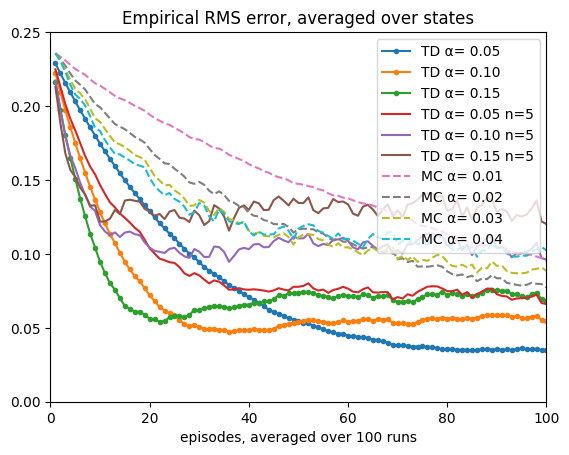

In [10]:
nstepTD_MC_randwalk()

## Comparison of online n-step TD and MC for different α
Ok, let us now study the effect of varying the hyperparameter n. n blends the horizon of all methods between bootstrapping algorithms and non-bootstrapping methods. To that end, we will apply TDn with different n values along with MC on a random walk prediction problem. This time we will use 19 states, and the goal to the left has a reward of -1, the goal on the right has a reward of 1, and all of the 19 intermediate states have a reward of 0.

In [11]:
def nstepTD_MC_randwalk_αcompare(env=randwalk_(), algorithm=TDn, Vstar=None, runs=10, envlabel='19', 
                                 MCshow=True, alglabel='online TD'):
    
    steps0 = list(np.arange(.001,.01,.001))
    steps1 = list(np.arange(.011,.2,.025))
    steps2 = list(np.arange(.25,1.,.05))

    αs = np.round(steps0 +steps1 + steps2, 2)
    #αs = np.arange(0,1.05,.1) # quick testing
    
    plt.xlim(-.02, 1)
    plt.ylim(.24, .56)
    plt.title('n-steps %s RMS error averaged over %s states and first 10 episodes'%(alglabel,envlabel))
    for n in [2**_ for _ in range(10)]:
        Compare(algorithm=algorithm(env=env, v0=0, n=n, episodes=10, Vstar=Vstar), 
                              runs=runs, 
                              hyper={'α':αs}, 
                              plotE=True).compare(label='n=%d'%n)
    if MCshow:
        compare = Compare(algorithm=MC(env=env, v0=0, episodes=10), 
                                  runs=runs, 
                                  hyper={'α':αs}, 
                                  plotE=True).compare(label='MC ≡ TDn(n=$\\infty$)', frmt='-.')

100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|█████████████████████████████████████████████████████████████████████████████

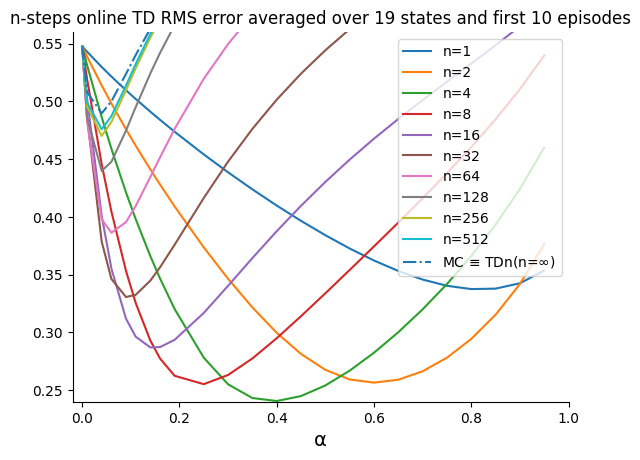

In [12]:
figure_7_2 = nstepTD_MC_randwalk_αcompare
figure_7_2()

Note how when n=$\infty$ TDn converges to an MC. Hence, we could see that TDn represents the full spectrum of algorithms that completely use bootstrapping (TD) and algorithms that do not use bootstrapping (MC). It nicely blends these algorithms and lets us control bootstrapping parametrically by choosing a suitable value for the n hyperparameter.

## Offline TDn 
Let us now develop an offline TDn method. This method is exactly as its name suggests. We need to be mindful of going n-1 extra steps at the end because of the lag of n-1 steps at the start until the agent accumulates enough steps to obtain the $G_{t:t+n}$.

In [13]:
class TDnf(MRP):

    def init(self):
        self.store = True # must store because it is offline

    # ----------------------------- 🌘 offline TD learning ----------------------------   
    def offline(self):
        n=self.n        
        for t in range(self.t+n): # T+n to reach T+n-1
            τ  = t - (n-1)
            if τ<0: continue
        
            # we take the min so that we do not exceed the episode limit (last step+1)
            τ1 = τ+1
            τn = τ+n ; τn=min(τn, self.t+1)
            
            sτ = self.s[τ ]
            sn = self.s[τn]
            done = self.done[τn]
            
            # n steps τ+1,..., τ+n inclusive of both ends
            self.V[sτ] += self.α*(self.G(τ1,τn)+ (1- done)*self.γ**n *self.V[sn] - self.V[sτ])

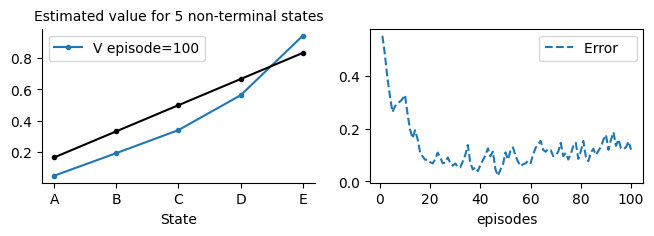

In [14]:
TDnwalk = TDnf(env=randwalk(), v0=0, α=.1, n=4, episodes=100, seed=0, **demoV()).interact()

In [15]:
TDnwalk.t

18

In [16]:
TDnwalk.Ts

array([ 3,  7,  9, 15, 11,  5,  3,  5, 13, 27,  9,  3, 11,  3, 11,  7,  7,
        7, 13,  3,  7,  5, 15,  7,  5, 13,  3, 23, 13,  9,  3,  7,  9, 17,
       13, 17,  9, 13,  9,  3,  3, 29,  3, 15,  7,  3,  3, 19,  9,  3, 15,
        3,  3,  3, 19,  3, 15,  3,  3,  9,  5,  3,  3,  7,  3,  3,  3,  5,
        3, 11,  7, 11,  3,  5,  9,  5,  3, 19,  5,  9,  5,  3,  5,  3,  5,
        3,  3,  9, 11,  9,  7,  5,  9,  7,  9,  3,  3, 15,  7, 19],
      dtype=uint32)

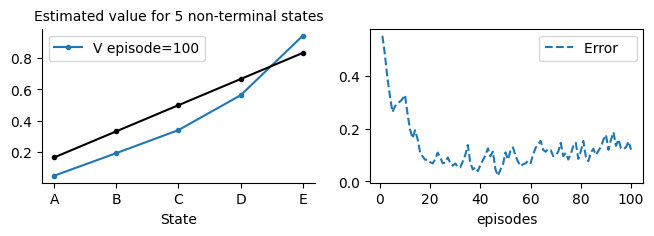

In [17]:
TDnwalk = TDnf(env=randwalk(), v0=0, α=.1, n=4, episodes=100, seed=0, **demoV()).interact()

In [18]:
TDnwalk.t

18

In [19]:
TDnwalk.Ts

array([ 3,  7,  9, 15, 11,  5,  3,  5, 13, 27,  9,  3, 11,  3, 11,  7,  7,
        7, 13,  3,  7,  5, 15,  7,  5, 13,  3, 23, 13,  9,  3,  7,  9, 17,
       13, 17,  9, 13,  9,  3,  3, 29,  3, 15,  7,  3,  3, 19,  9,  3, 15,
        3,  3,  3, 19,  3, 15,  3,  3,  9,  5,  3,  3,  7,  3,  3,  3,  5,
        3, 11,  7, 11,  3,  5,  9,  5,  3, 19,  5,  9,  5,  3,  5,  3,  5,
        3,  3,  9, 11,  9,  7,  5,  9,  7,  9,  3,  3, 15,  7, 19],
      dtype=uint32)

### TDf and TDnf for n=1

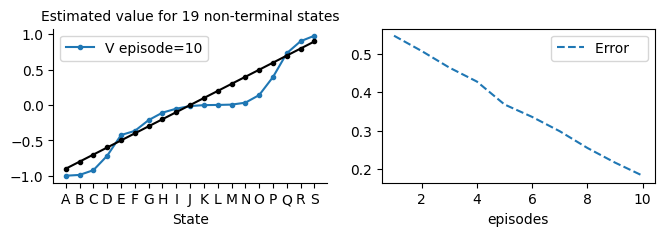

In [20]:
TDnwalk = TDf(env=randwalk_(), v0=0, α=.8, episodes=10, seed=0, **demoV()).interact()

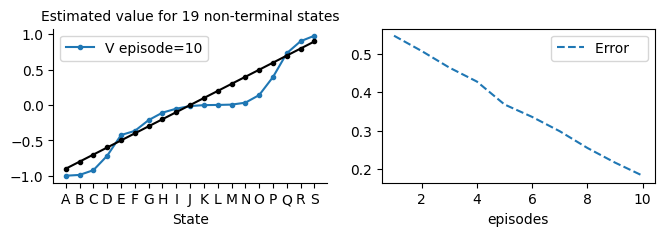

In [21]:
TDnwalk = TDnf(env=randwalk_(), v0=0, α=.8, n=1, episodes=10, seed=0, **demoV()).interact()

### TDf , TDnf and MC Runs on random walk
Let us now  see how a TDnf for n=1 and n=5 as well as MC behaves on our usual 5-states random walk on average. To that end as usual we execute several runs.

100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|███████████████████████████████████████████████████████████

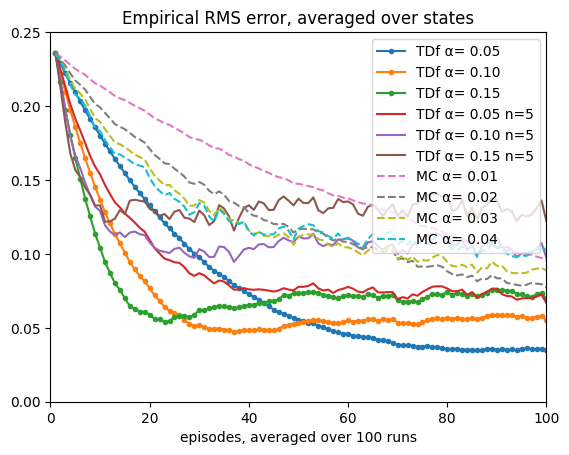

In [22]:
nstepTD_MC_randwalk(algorithm=TDnf, alglabel='TDf')

Let us now double check that both TDnf and TDf are identical for n=1.

In [23]:
from tqdm import trange, tqdm

100%|██████████████████████████████████████████████████████████████████████████████████████████|11/11
100%|██████████████████████████████████████████████████████████████████████████████████████████|11/11


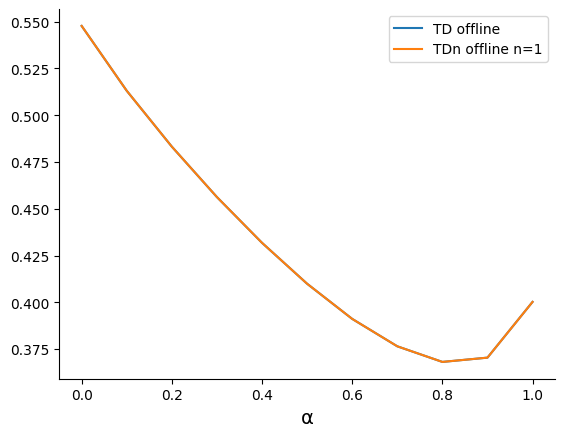

In [24]:
αs = np.arange(0,1.05,.1)
n=1
compareTDf = Compare(algorithm=TDf(env=randwalk_(), v0=0, episodes=10), runs=2, hyper={'α':αs}, 
                     plotE=True).compare(label='TD offline')

compareTDnf = Compare(algorithm=TDnf(env=randwalk_(), v0=0, n=n, episodes=10), runs=2, hyper={'α':αs}, 
                      plotE=True).compare(label='TDn offline n=%d'%n)

## Offline TDnf α comparison 
Let us now compare how offline n-step TD (TDnf) performs with different values for α (learning-step hyper parameter.

100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|█████████████████████████████████████████████████████████████████████████████

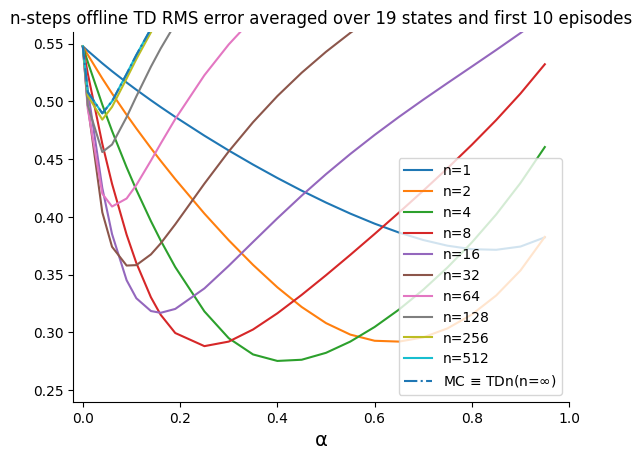

In [25]:
nstepTD_MC_randwalk_αcompare(algorithm=TDnf, alglabel='offline TD')

# n-step Sarsa on-policy Control

As you can see, we have imported the class factory MDP to make it inherit the new MRP class that we defined in this lesson (which contains functions to deal with multiple steps updates) without having to restate the definition of MDP again.

In [26]:
class Sarsan(MDP(MRP)):

    def init(self):
        self.store = True        # although online but we need to access *some* of earlier steps,
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t
    
    # ----------------------------- 🌖 online learning ----------------------    
    def online(self,*args):
        τ = self.t - (self.n-1);  n=self.n
        if τ<0: return
        
        # we take the min so that we do not exceed the episode limit (last step+1)
        τ1 = τ+1
        τn = τ+n ; τn=min(τn, self.t+1 - self.skipstep)
        
        sτ = self.s[τ];  aτ = self.a[τ]
        sn = self.s[τn]; an = self.a[τn]
        done = self.done[τn]
        
        # n steps τ+1,..., τ+n inclusive of both ends
        self.Q[sτ,aτ] += self.α*(self.G(τ1,τn) + (1- done)*self.γ**n *self.Q[sn,an] - self.Q[sτ,aτ])

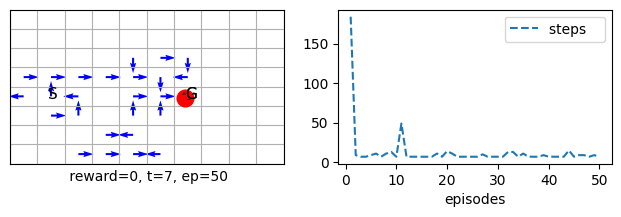

In [27]:
nsarsa = Sarsan(env=grid(), n=10, α=.4, episodes=50, seed=0,  **demoQ()).interact()

In [28]:
for seed in range(100):
    nsarsa = Sarsan(env=grid(), α=.4, seed=seed, episodes=1).interact()
    if len(nsarsa.env.trace) <15: print(seed)

16
47


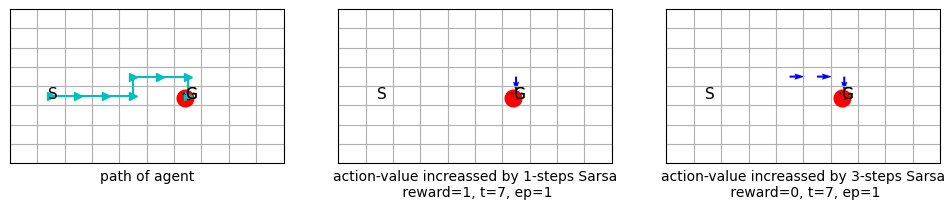

In [29]:
def figure_7_4(n=5,seed=16): 
    
    # draw the path(trace) that the agent took to reach the goal
    nsarsa = Sarsan(env=grid(), α=.4, seed=seed, episodes=1).interact()
    nsarsa.env.render(underhood='trace', subplot=131, animate=False, label='path of agent')

    # now draw the effect of learning to estimate the Q action-value function for n=1
    nsarsa = Sarsan(env=grid(), α=.4, seed=seed, episodes=1, underhood='maxQ').interact() 
    nsarsa.render(subplot=132, animate=False, label='action-value increassed by 1-steps Sarsa\n')
    
    #n=5 # try 10
    # now draw the effect of learning to estimate the Q action-value function for n=10
    nsarsa = Sarsan(env=grid(), n=n, α=.4, seed=seed, episodes=1, underhood='maxQ').interact()    
    nsarsa.render(subplot=133, animate=False, label='action-value increassed by %d-steps Sarsa\n'%n)

figure_7_4(n=3)

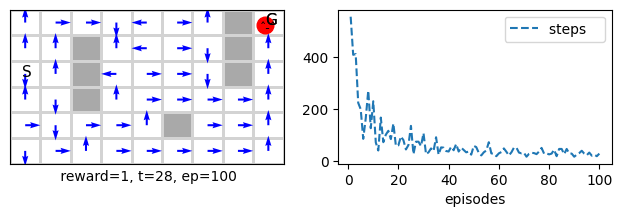

In [30]:
sarsa = Sarsa(env=maze(reward='reward1'),  α=.2, episodes=100, seed=10, **demoQ()).interact()
# sarsa = Sarsan(env=maze(reward='reward1'), n=1, α=.2, episodes=100, seed=10, **demoQ()).interact() # same as above

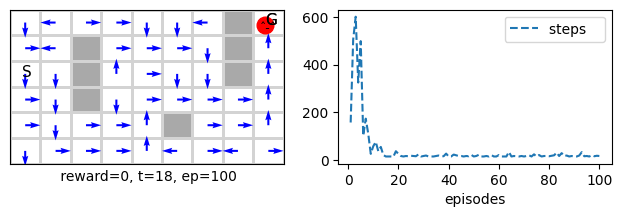

In [31]:
sarsa = Sarsan(env=maze(reward='reward1'), n=10,  α=.2, episodes=100, seed=10, **demoQ()).interact()

Note how the agent reaches a better policy in less number of episodes, i.e. it converges faster when using n-step method. At the end it counted a extra n-1 steps to finish the set of n-1 updates needed at the end of the episode.

## n-step Q-learning
Can we implement an n-step Q-learning algorithm?

If we think about this question superficially, from an implementation perspective, the answer seems simple. All we have to do is to replace the $γ^n*Q[sn,an]$ with $γ^n*Q[sn].max()$. However, this is *not the correct* way to implement the n-step off-policy Q-learning. 

Remember that Q-learning is an action-value learning method that uses TD learning off-policy, where we learn about a greedy policy while following a more exploratory policy, such as ε-greedy. To be able to generalise the n-step TD update to an off-policy action-value method, we need to take into account the following. In each step of the n-steps that we are considering, we need our method to learn what the agent *would have done* if it had followed a π=greedy policy (instead of the b=εgreedy). 

One way to compensate for this discrepancy between the behavioural policy b and the target policy π would be to multiply each reward of the $G_{t:t+n}$ with the importance sampling ratio. This ratio divides the probability of taking action *a* from policy π by the probability of taking the same action according to policy b. Importance sampling methods suffer from high variance, and usually, they are not practical for control.

Another approach is by using expectation instead of importance sampling. In this case, we use a similar idea to the expected Sarsa but in an off-policy context, where we alter the calculation of $G_{t:t+n}$ in a way that sums over the different actions probabilities in each time step (except the first). This results in an algorithm called the Tree Backup Algorithm.

Finally, we can blend the importance sampling with expectation using a hyperparameter σ which results in the Q(σ) control algorithm. All of the above three approaches are outside the scope of our coverage, and there is a theory behind this choice. See section 7.3 of our textbook.


## Conclusion
In this lesson, we have covered the n-step TD algorithms for prediction and control. We have seen how the different values of n represent a trade-off between full bootstrapping, as in the one-step TD (n=1), and no bootstrapping, as in the Monte Carlo algorithm (n=T the number of steps in an episode). Intermediate n values give algorithms that lie within the two extremes of the spectrum of bootstrapping algorithms. We also find that the best value is usually an intermediate value >1. As we have seen, creating such an algorithm is challenging and has its drawbacks in terms of implementation. In later lessons, we will see how to achieve similar results without waiting or counting steps. We will adopt a bootstrapping variation mechanism which turns the n-step countable mechanism into an infinite continuum of value by adopting the $\lambda$ hyperparameter that takes a real value instead of integers.

## Your turn
1. implement the incorrect n-step Q-learning and apply it on the maze problem and see how it performs.
2. implement n-step Expected Sarsa and compare its performance with the n-step Sarsa.


## Challenge
Try to implement the correct off-policy n-step Sarsa presented in page 149 of the textbook.

[Back to TOC](IntroductionTOC.ipynb)